# Energy scan with pilatus
December 14, 2023
awojdyla@lbl.gov

## Setting up the experiment and controls

### import the python packages

In [2]:
#required packages
import epics
import numpy

### Testing EPICS communication

In [3]:
# reading the monochromator angle
epics.caget('bl531_xps1:mono_angle_deg')

CA.Client.Exception...............................................
    Context: "Channel: "bl531_xps1:mono_angle_deg", Connecting to: 131.243.80.239:5064, Ignored: 192.168.10.123:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Dec 14 2023 11:16:21.153735074
..................................................................


30.0

In [64]:
# mvoing the monochromator if needed
mono_angle_deg = 55
epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)

1

In [65]:
# trigerring an acquisition on the pilatus camera
# acquisition settings (filename, exp time, etc. are stored in the IOC)
epics.caput('13PIL1:cam1:Acquire',1)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()

### Reading an image from the camera
after it has been stored on the shared drive (bl531data.lbl.gov), mounted as `/mnt/pilatus/`

In [66]:
#read a image
import numpy as np
from PIL import Image

filepath = '/mnt/pilatus/calib_20231214_001.tif'
filepath = '/mnt/pilatus/' + last_filename[13:-1] 

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))


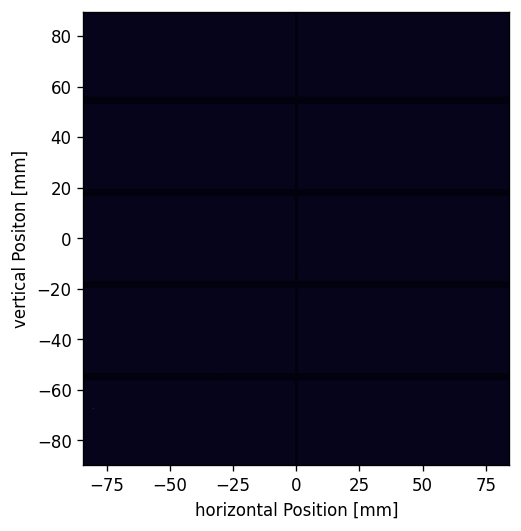

In [97]:
# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

mask = im_np > np.max(im_np)
im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

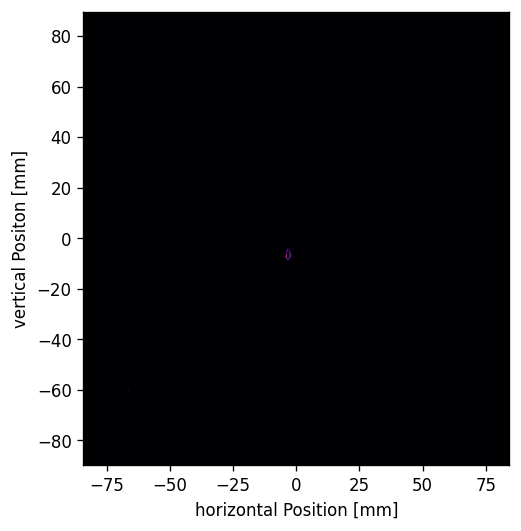

In [102]:
# mvoing the monochromator if needed
mono_angle_deg = 26
#epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
#time_sleep(5)

epics.caput('13PIL1:cam1:Acquire',1)
time_sleep(2)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()

filepath = '/mnt/pilatus/calib_20231214_001.tif'
filepath = '/mnt/pilatus/' + last_filename[13:-1] 

from time import sleep as time_sleep


im_tiff = Image.open(filepath)
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))
# dealing with dyanmic range
im_np[np.where(im_np>10000.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

mask = im_np > np.max(im_np)
im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

### Creating a script to translate photon energy in monochromator angle
the calibration may be slightly off from a changed M1 angle -- `mono_offset_deg = 12.787`

In [18]:
#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
#Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
#Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg
mono_deg(3000)

54.02126444371078

In [69]:
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()[13:-1] 
last_filename

'calib_20231214_014.tif'

## Acquiring images through an energy scan
AgB particles measured near the Cu K-edge (~9kev)

In [82]:
from time import sleep as time_sleep
# there's no settling time in EPICS so we use `sleep` to enforce a guard time after motion

Es_eV = np.linspace(3500, 9500, 61)
time_sleep(30)
filenames = ()
for i_e in range(len(Es_eV)):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    #print(mono_angle_deg)
    time_sleep(5)
    epics.caput('13PIL1:cam1:Acquire',1)
    last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
    last_filename = bytes(last_filename_ascii).decode()[13:-1]
    filenames += (last_filename,)

In [83]:
img = ()
for i_e in range(len(Es_eV)):
    filepath = '/mnt/pilatus/' + filenames[i_e] 
    # read the image
    im_tiff = Image.open(filepath)
    # make the image a numpy array so that we can process it
    im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))
    img += (im_np,)


In [84]:
flux = Es_eV*0
for i_e in range(len(Es_eV)):
    flux[i_e] = np.sum(img[i_e])

In [85]:
flux

array([1.57905765e+08, 1.27848438e+08, 8.71975250e+07, 4.67633400e+07,
       2.07672590e+07, 2.51455140e+07, 3.00237950e+07, 3.52351100e+07,
       4.08492560e+07, 4.67049870e+07, 5.23026550e+07, 5.76729640e+07,
       6.27707710e+07, 6.74340650e+07, 7.19818370e+07, 7.65227490e+07,
       8.01369100e+07, 8.40369720e+07, 8.77450320e+07, 9.10247780e+07,
       9.45696820e+07, 9.78520630e+07, 1.00814196e+08, 1.03952704e+08,
       1.07117561e+08, 1.09678863e+08, 1.12401619e+08, 1.15152563e+08,
       1.17952355e+08, 1.20411101e+08, 1.22693623e+08, 1.25152986e+08,
       1.27584570e+08, 1.29805513e+08, 1.31777993e+08, 1.33844346e+08,
       1.35825125e+08, 1.37778820e+08, 1.39876511e+08, 1.41548491e+08,
       1.43356582e+08, 1.45096020e+08, 1.46771020e+08, 1.48503664e+08,
       1.50205249e+08, 1.51808169e+08, 1.53211715e+08, 1.54511038e+08,
       1.55773475e+08, 1.56723048e+08, 1.57319343e+08, 1.57877144e+08,
       1.58282813e+08, 1.58578799e+08, 1.58726245e+08, 1.58840211e+08,
      

Text(0, 0.5, 'flux')

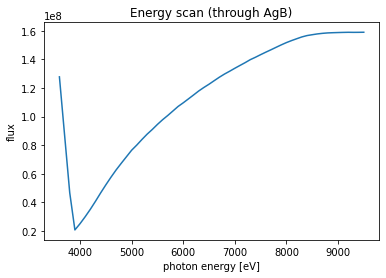

In [87]:
plt.plot(Es_eV[1:],flux[1:])
plt.title('Energy scan (through AgB)')
plt.xlabel('photon energy [eV]')
plt.ylabel('flux')